In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

In [2]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [3]:
data_train=pl.read_parquet('data/data_full_train.parquet')
data_val=pl.read_parquet('data/data_full_val.parquet')

In [4]:
data_train=dmf.clean_accepted_rejected(data_train)
data_val=dmf.clean_accepted_rejected(data_val)

data_train=feats.date_features_accepted_rejected(data_train,"Application Date")
data_val=feats.date_features_accepted_rejected(data_val,"Application Date")

data_train=feats.title_text_features(data_train)
data_val=feats.title_text_features(data_val)

In [5]:
data_train=feats.title_text_features(data_train)
data_train=feats.title_text_features(data_train)

In [6]:
X_train = data_train.drop(columns=['Policy Code'])
X_val= data_val.drop(columns=['Policy Code'])
y_train = data_train['Policy Code']
y_val= data_val['Policy Code']

In [7]:
X_mini_train, discard1, y_mini_train, discard2 = train_test_split(
    X_train, y_train, stratify=y_train,train_size=3000000
)

X_mini_val, X_val, y_mini_val, y_val = train_test_split(
    X_val, y_val, stratify=y_val,train_size=900000
)

## Pipelines

### LightGBM

In [8]:
X_mini_train.null_count()

Amount Requested,Debt-To-Income Ratio,Zip Code,State,Employment Length,title,month_sin,month_cos,title_contains_numbers,title_length,title_starts_with_lowercase
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
182,170705,37,5,115898,6033,0,0,6033,6033,6033


#### Imputers

In [9]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=50,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=51,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)


imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("title_imp",title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step("zip_code_imp", zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step("state_imp",state_imputer, "State"),
        tr.PolarsColumnTransformer.Step("len_imp",emp_length_imputer, "Employment Length"),
    ]
)

#### Encoders and selection

In [10]:
state_encoder = tr.TargetMeanOrderedLabeler()
zip_encoder = tr.TargetMeanOrderedLabeler()
title_encoder = tr.TargetMeanOrderedLabeler()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder = tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step("state", state_encoder, "State"),
        tr.PolarsColumnTransformer.Step("zip_code",zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step("title", title_encoder, "title"),
        tr.PolarsColumnTransformer.Step("emp_length", employment_encoder, "Employment Length"),
    ]
)
null_imp = tr.PolarsNullImputer(fill_value=-9)

model_lgbm = lgb.LGBMClassifier(
    class_weight="balanced",
    force_col_wise=True,
    verbose=-1,
    num_threads=1,
    random_state=1,
)

boruta = tr.BorutaFeatureSelectorPolars(model_lgbm, random_state=1, perc=100)

preprocess_lgbm = Pipeline(
    [
        ("imputer", imputer),
        ("encoder", encoder),
        ("null_imputer", null_imp),
        ("boruta", boruta),
    ]
)

#### Baseline for tunning

In [16]:
model_lgbm.fit(
    preprocess_lgbm.fit_transform(
        X_mini_train.sample(100000, seed=1), y_mini_train.sample(100000, seed=1)
    ),
    y_mini_train.sample(100000, seed=1),
)
baseline_preds=model_lgbm.predict(preprocess_lgbm.transform(X_mini_val.sample(30000,seed=1)))
print(f1_score(y_mini_val.sample(30000,seed=1),baseline_preds))

0.6179696616102685


In [11]:
full_pipeline = Pipeline(
    [
        ("preprocess", preprocess_lgbm),
        ("model", model_lgbm),
    ]
)

search_space_lgbm = {
    "preprocess__boruta__perc": tune.randint(1, 100),
    "preprocess__boruta__apply": tune.choice([True, False]),
    "model__num_leaves": tune.randint(10, 150),
    "model__n_estimators": tune.randint(1, 250),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 10),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 200),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models = tunes.Models()
models.add_model("lgbm_yn", full_pipeline, search_space_lgbm, metric_threshold=0.6)

### Tree

In [12]:
imputer_tree = copy.deepcopy(imputer)
encoder_tree = copy.deepcopy(encoder)
null_imp_tree = copy.deepcopy(null_imp)
preprocess_tree = Pipeline(
    [
        ("imputer", imputer_tree),
        ("encoder", encoder_tree),
        ("null_imputer", null_imp_tree),
    ]
)

model_tree = DecisionTreeClassifier()

full_pipeline_tree = Pipeline(
    [
        ("preprocess", preprocess_tree),
        ("model", model_tree),
    ]
)

search_space_tree = {
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "tree_yn", full_pipeline_tree, search_space_tree, metric_threshold=0.55
)

### Logreg

In [23]:
imputer_logreg = copy.deepcopy(imputer)
encoder_logreg = copy.deepcopy(encoder)
null_imp_logreg = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(
            "dti_imp", tr.PolarsNullImputer(10000), "Debt-To-Income Ratio"
        ),
        tr.PolarsColumnTransformer.Step(
            "requested_imp", tr.PolarsNullImputer(0), "Amount Requested"
        ),
        tr.PolarsColumnTransformer.Step(
            "contains_num_imp", tr.PolarsNullImputer(0), "title_contains_numbers"
        ),
        tr.PolarsColumnTransformer.Step(
            "lowercase_imp", tr.PolarsNullImputer(0), "title_starts_with_lowercase"
        ),
        tr.PolarsColumnTransformer.Step(
            "title_len_imp", tr.PolarsNullImputer(0), "title_length"
        ),
    ]
)

scaler=StandardScaler()

preprocess_logreg = Pipeline(
    [
        ("imputer", imputer_logreg),
        ("encoder", encoder_logreg),
        ("null_imputer", null_imp_logreg),
        ("scaler", scaler)
    ]
)

model_logreg = LogisticRegression(class_weight="balanced", max_iter=2000, tol=0.01)

full_pipeline_logreg = Pipeline(
    [
        ("preprocess", preprocess_logreg),
        ("model", model_logreg),
    ]
)

search_space_logreg = {
    "model__class_weight":tune.choice(['balanced',None]),
    "model__penalty": tune.choice(
        [
            "l1",
            "l2",
            None
        ]
    ),
    "model__C": tune.loguniform(0.001, 10.0),
    "model__solver": tune.choice(["saga"]),
    "preprocess__encoder__step_params": {
        "state": {"how": tune.choice(["label", "mean"])},
        "zip_code": {"how": tune.choice(["label", "mean"])},
        "title": {"how": tune.choice(["label", "mean"])},
    },
}

models.add_model(
    "logreg_yn",
    full_pipeline_logreg,
    search_space_logreg,
    metric_threshold=0.5,
    override_n=52,
)

In [25]:
# models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=120,sample_size=300000)
# joblib.dump(models, 'models_yn.joblib')
# models=joblib.load('models_yn.joblib')


['models_yn.joblib']

##### Features dropped by Boruta:

In [41]:
selected_features = (
    models.models["lgbm_yn"]
    .pipeline["preprocess"]
    .fit_transform(
        X_mini_train.sample(200000, seed=1), y_mini_train.sample(200000, seed=1)
    )
    .columns
)
features_to_drop = [
    feature for feature in X_mini_train.columns if feature not in selected_features
]
features_to_drop

['title_contains_numbers', 'title_starts_with_lowercase']

##### Dropping features manually instead of Boruta algorithm:

In [46]:
models.models["lgbm_yn"].pipeline["preprocess"].steps.pop(-1)
models.models["lgbm_yn"].pipeline["preprocess"].steps.append(
    ("feature_remover", tr.FeatureRemover(feats_to_drop=features_to_drop))
)

In [62]:
# models.models['lgbm_yn'].pipeline.fit(X_train,y_train)
# models.models['logreg_yn'].pipeline.fit(X_train,y_train)
# models.models['tree_yn'].pipeline.fit(X_train,y_train)


In [61]:
# joblib.dump(models,'trained_models_yn')

['trained_models_yn']

In [11]:
models.models['lgbm_yn'].best_params

{'preprocess__boruta__perc': 42,
 'preprocess__boruta__apply': True,
 'model__num_leaves': 123,
 'model__n_estimators': 121,
 'model__learning_rate': 0.06089891117069649,
 'model__bagging_freq': 7,
 'model__colsample_bytree': 0.5431419823122927,
 'model__subsample': 0.797356373150579,
 'model__reg_alpha': 0.002398345317591261,
 'model__reg_lambda': 0.6480071661851624,
 'model__boosting_type': 'rf',
 'model__class_weight': None,
 'model__max_bin': 157,
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'label'},
  'title': {'how': 'label'}}}

In [10]:
models.models['tree_yn'].best_params

{'model__criterion': 'entropy',
 'model__splitter': 'best',
 'model__max_depth': 7,
 'model__max_features': None,
 'model__class_weight': None,
 'preprocess__encoder__step_params': {'state': {'how': 'label'},
  'zip_code': {'how': 'label'},
  'title': {'how': 'label'}}}

In [12]:
models.models['logreg_yn'].best_params

{'model__class_weight': 'balanced',
 'model__penalty': 'l1',
 'model__C': 0.4464135199892934,
 'model__solver': 'saga',
 'preprocess__encoder__step_params': {'state': {'how': 'mean'},
  'zip_code': {'how': 'mean'},
  'title': {'how': 'label'}}}

In [9]:
models=joblib.load('trained_models_yn')

In [10]:
preds_lgbm =models.models['lgbm_yn'].pipeline.predict(X_val)
# preds_logreg =models.models['logreg_yn'].pipeline.predict(X_val)
preds_tree =models.models['tree_yn'].pipeline.predict(X_val)
# 

In [11]:
print(classification_report(y_val,preds_lgbm))
# print(classification_report(y_val,preds_logreg))
print(classification_report(y_val,preds_tree))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98   1993641
           1       0.63      0.74      0.68    103966

    accuracy                           0.97   2097607
   macro avg       0.81      0.86      0.83   2097607
weighted avg       0.97      0.97      0.97   2097607

              precision    recall  f1-score   support

           0       0.98      0.98      0.98   1993641
           1       0.65      0.65      0.65    103966

    accuracy                           0.97   2097607
   macro avg       0.82      0.82      0.82   2097607
weighted avg       0.97      0.97      0.97   2097607



In [12]:
best_pipeline=models.models['lgbm_yn'].pipeline

100%|===================| 9991/10000 [00:30<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


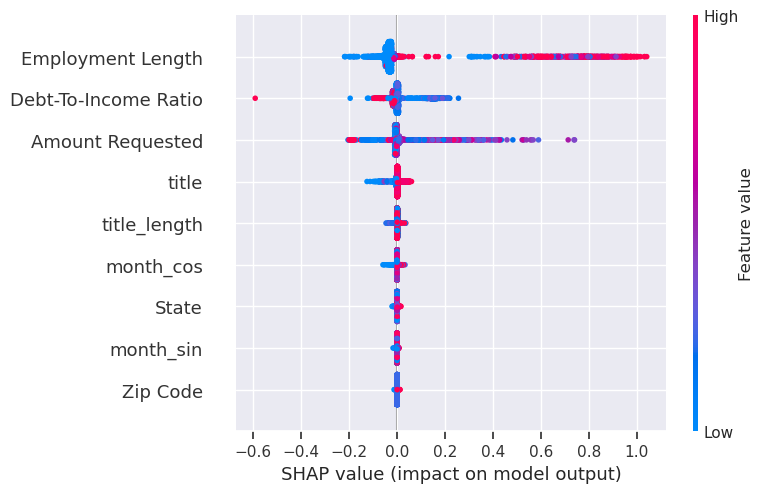

In [13]:
names = best_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    best_pipeline["model"],
    data=best_pipeline["preprocess"]
    .transform((X_mini_val.sample(10000, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    best_pipeline["preprocess"].transform(X_mini_val.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)

In [15]:
best_pipeline.fit(X_train.vstack(X_val), pl.concat([y_train,y_val]))

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=OrderedDict([('title_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fb42ba53d30>),
                                                                             ('zip_code_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step object at 0x7fb42ba53c70>),
                                                                             ('state_imp',
                                                                              <functions.transformers.PolarsColumnTransformer.Step ob...
                 LGBMClassifier(bagging_freq=7, boosting_type='rf',
                                colsample_bytree=0.5431419823122927,
                                force_col_wise=True,
                                learning_rate=0.06089891117069649, max_bin=157,
                                n_estimators=121, num_leaves=123, num_threads=1,
                                random_state=RandomState(MT19937) at 0x7FB69AEA2B40,
                                reg_alpha=0.002398345317591261,
                                reg_lambda=0.6480071661851624,
                                subsample=0.797356373150579, verbose=-1))])

In [16]:
data_test=pl.read_parquet('data/data_full_test.parquet')

In [17]:
data_test=dmf.clean_accepted_rejected(data_test)
data_test=feats.date_features_accepted_rejected(data_test,"Application Date")
data_test=feats.title_text_features(data_test)

X_test = data_test.drop(columns=["Policy Code"])
y_test = data_test["Policy Code"]

In [18]:
final_preds = best_pipeline.predict(X_test)
print(classification_report(data_test["Policy Code"], final_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98   6647748
           1       0.64      0.73      0.68    346669

    accuracy                           0.97   6994417
   macro avg       0.81      0.86      0.83   6994417
weighted avg       0.97      0.97      0.97   6994417



In [21]:
# best_pipeline.fit(X_train.vstack(X_val).vstack(X_test), pl.concat([y_train,y_val,y_test]))
joblib.dump(best_pipeline,"trained_models/final_model_accepted_rejected.joblib")

['trained_models/final_model_accepted_rejected.joblib']